# Séance 6

## Objectifs de la séance

- Résolution graphique de la détermination d'un correcteur PD
- Résolution graphique de la détermination d'un correcteur PID

In [1]:
from IPython.display import Image, display, Markdown

from control import matlab as ml  # Python Control Systems Toolbox (compatibility with MATLAB)
import numpy as np              # Library to manipulate array and matrix
import matplotlib.pyplot as plt # Library to create figures and plots
import math # Library to be able to do some mathematical operations
import ReguLabFct as rlf # Library useful for the laboratory of regulation of HELMo Gramme

## Régulateur PD

### Exercice 6 page 7-15 (fait au cours)

Soit la fonction de boucle ouverte d'un processus: 

$$G(p)={\frac {1}{p(1+0,1p)(1+p)}}$$

On demande de déterminer *graphiquement* le correcteur PD de manière à optimiser le temps de réponse du système, à garantir une erreur de vitesse de 10% et une marge de phase de 45°.

#### Solution:

Fixer l'erreur de vitesse à 10% impose le gain: $\varepsilon_v={\frac{1}{K_P}}=0.1$ d'où $K_P=10$ puisque le système est de classe 1 (*cf. p. 6-3*).

In [2]:
# Fonction de transfert en boucle ouverte
G1 = ml.tf(1, [1, 0])
G2 = ml.tf(1, [0.1, 1])
G3 = ml.tf(1, [1, 1])
G = G1*G2*G3  # G de l'énoncé 

MP = 45 # Marge de phase réclamée
Kp = 10

Pour choisir la constante de temps de dérivation, nous avons deux possibilités:
1. Compensation du pôle dominant
2. Placement fréquentiel

##### $1^{ère}$ méthode: Compensation du pôle dominant

$\tau_d=1$ et nous vérifions les performances obtenues pour le système corrigé.

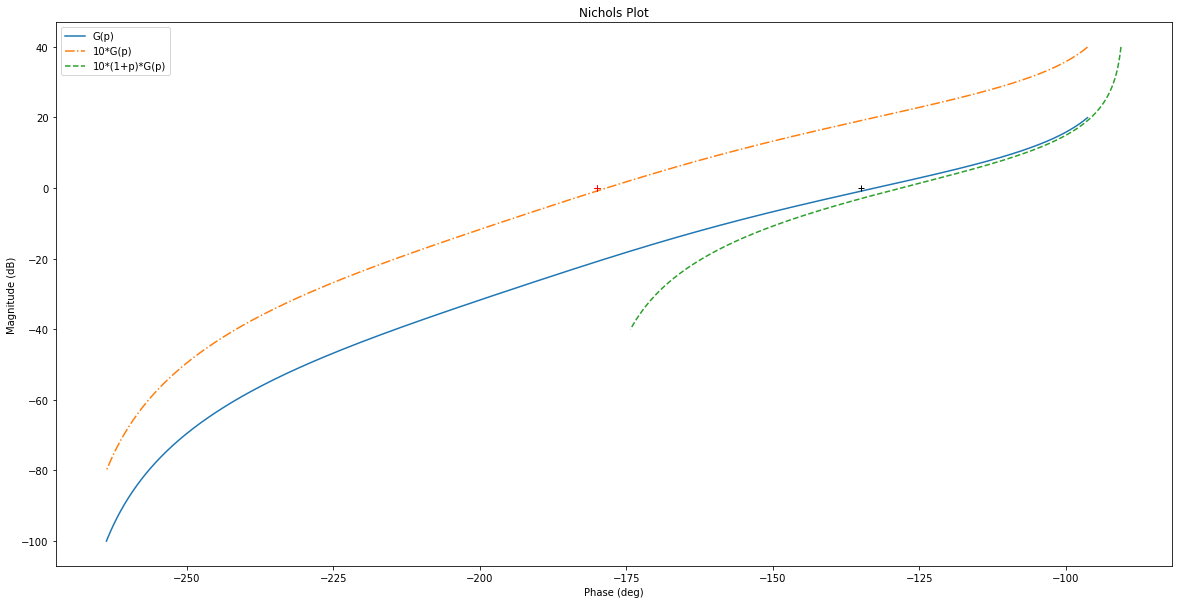

In [3]:
tD = 1
Corr = Kp*ml.tf([tD, 1],1)

fig = plt.figure("Nichols",figsize=(20,10))
ax = fig.subplots()
rlf.nichols(G, grid = False, labels=['G(p)'], NameOfFigure = "Nichols")
rlf.nichols(Kp*G, grid = False, labels=['10*G(p)'], NameOfFigure = "Nichols", linestyle = '-.')
rlf.nichols(Corr*G, grid = False, labels=['10*(1+p)*G(p)'], NameOfFigure = "Nichols", linestyle = '--')

ax.plot(-180+MP, 0,'k+'); # ; pour supprimer les lignes de sortie matplotlib

Les performances du système ainsi corrigé sont :


Système non corrigé
-------------------
DCGain : 0.9990781353814483
Overshoot : 20.71177518799896
Peak : 1.2060049527341057
PeakTime : 3.636378059961076
RiseTime : 1.5608835065561826
SettlingTime : 5.383265559354142

Système corrigé
---------------
DCGain : 0.9999999999999946
Overshoot : 16.30334988175648
Peak : 1.1630334988175586
PeakTime : 0.3626934214887111
RiseTime : 0.16373017312918958
SettlingTime : 0.5284961284549791


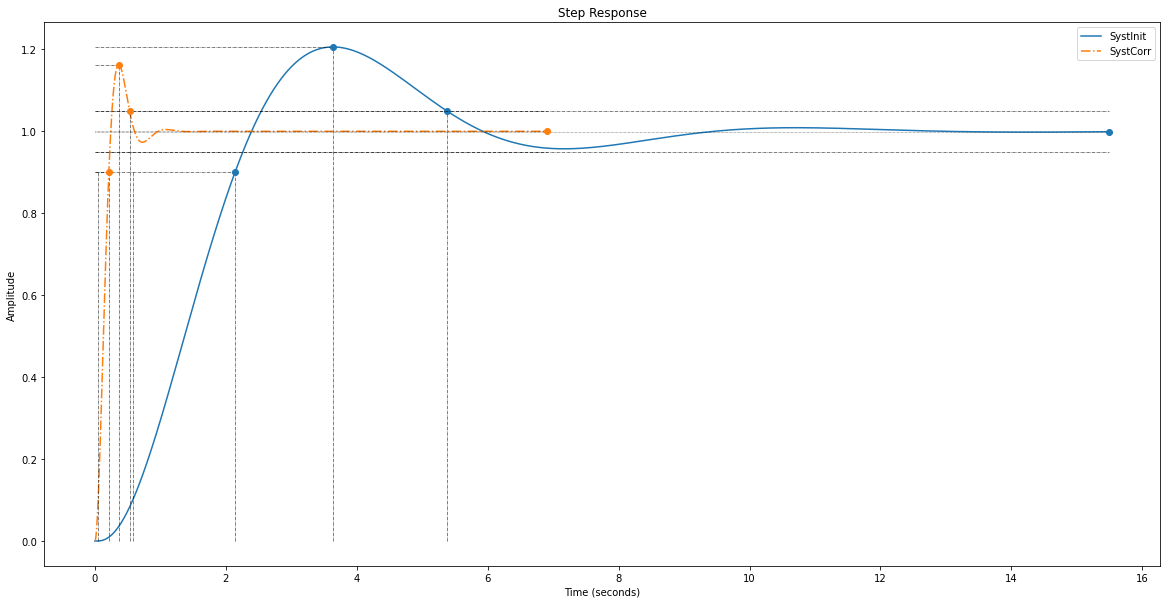

In [4]:
fig = plt.figure("Step Response",figsize=(20,10))

# Système non corrigé
# -------------------

Gbf = ml.feedback(G,1)
info = rlf.stepWithInfo(Gbf, NameOfFigure="Step Response", sysName='SystInit') # Renvoie toutes les infos du step

ep = (1-info.DCGain)*100 # Erreur de position

gm, pm, wg, wp = ml.margin(G) # Extract the gain margin (Gm) and the phase margin (Pm)

print("\nSystème non corrigé")
print("-------------------")
rlf.printInfo(info)

# Système corrigé
# ---------------
Gbf_PD = ml.feedback(Corr*G,1)
info_PD = rlf.stepWithInfo(Gbf_PD, NameOfFigure="Step Response", sysName='SystCorr', linestyle='-.') # Renvoie toutes les infos du step

ep_PD = (1-info_PD.DCGain)*100 # Erreur de position

gm, pm, wg, wp = ml.margin(Corr*G) # Extract the gain margin (Gm) and the phase margin (Pm)

print("\nSystème corrigé")
print("---------------")
rlf.printInfo(info_PD)

##### $2^{ème}$ méthode: placement fréquentiel

$K_P$ étant fixé, traçons $K_P*G(p)$ : le système est instable et nous allons nous efforcer de le
stabiliser par l’intermédiaire du terme $(1+\tau_D*p)$.

Ce terme a pour effet, pour la pulsation $\omega=\frac{10}{\tau_D}$, de translater le module de +20 dB et
d’introduire un déphasage de +90° (+84° pour être précis).

Comme nous voulons que le système en trait mixte soit corrigé et passe par le point
(0dB,-135°), cherchons le point qui a une phase de –135°-84° ; son module vaut -23 dB. Il
sera donc corrigé par le terme $(1+\tau_D*p)$ et passera *approximativement* par le point voulu
(0dB,-135°).

Sur la courbe en trait interrompu, le point (–23dB,–135°-84°) correspond à une pulsation de
9.9rad/s, soit : $\tau_D=\frac{10}{\omega_{à -135°-84°}}=\frac{10}{9.9}=1.01s$.

Gain à -219° = -42.869391796777016 dB
Fréquence à -219° = 9.91515778991914 rad/sec
tau_D = 1.01
Le système ainsi corrigé présente une marge de phase de 51.72° et une marge de gain de inf dB.


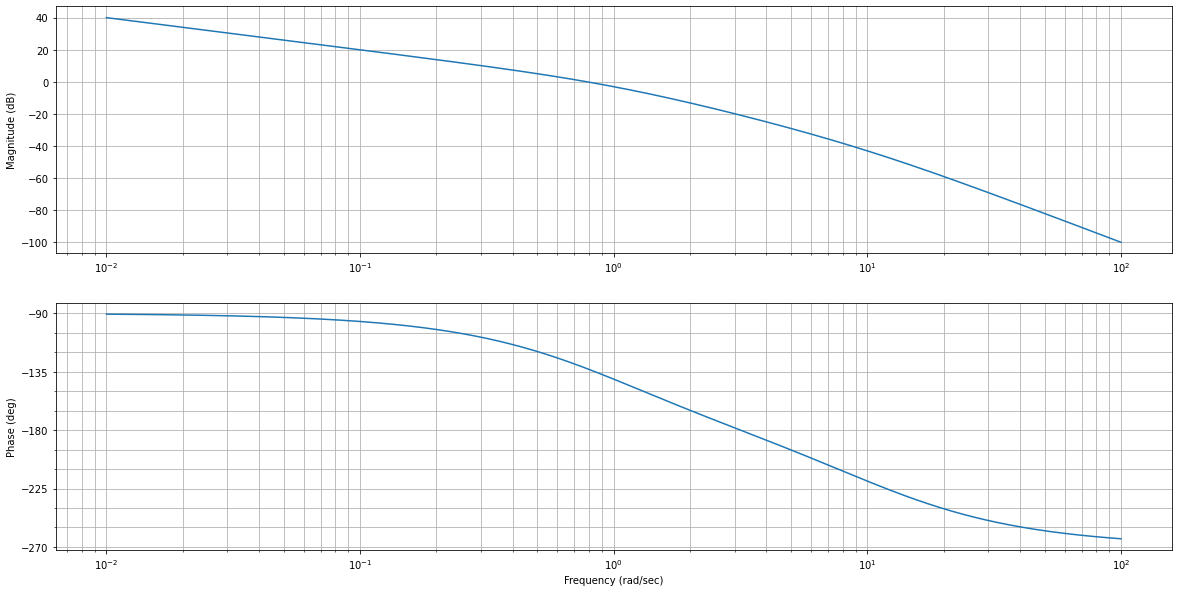

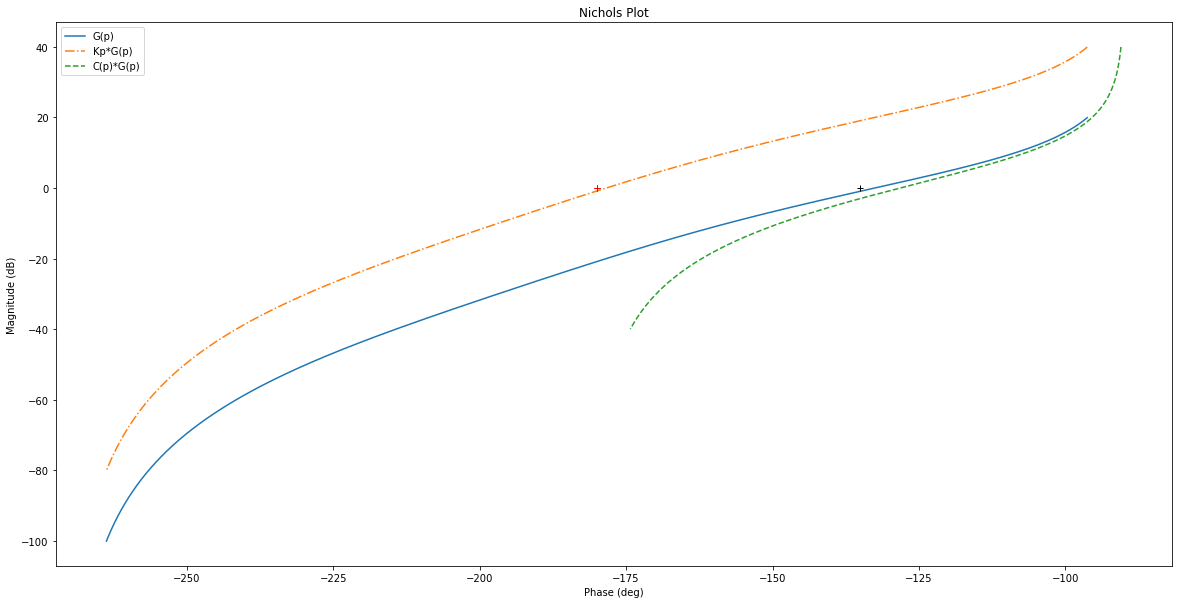

In [5]:
# Lecture phase
fig = plt.figure("Bode",figsize=(20,10))
mag, w = rlf.getValues(G, -180+MP-84, printValue=True, NameOfFigure="Bode")

# tD
tD = 10/w # = tD conseillé
print(f"tau_D = {tD:.2f}")
Corr = Kp*ml.tf([tD, 1],1)

fig = plt.figure("Nichols",figsize=(20,10))
ax = fig.subplots()
rlf.nichols(G, grid = False, labels=['G(p)'], NameOfFigure = "Nichols")
rlf.nichols(Kp*G, grid = False, labels=['Kp*G(p)'], NameOfFigure = "Nichols", linestyle = '-.')
rlf.nichols(Corr*G, grid = False, labels=['C(p)*G(p)'], NameOfFigure = "Nichols", linestyle = '--')

ax.plot(-180+MP, 0,'k+'); # Ajout du repère (+) par lequel on est censé passer

gm, pm, wg, wp = ml.margin(Corr*G) # Extrait la marge de gain (Gm) et de phase (Pm)
print(f"Le système ainsi corrigé présente une marge de phase de {pm:.2f}° et une marge de gain de {gm:.2f} dB.")


La marge de phase étant malgré tout toujours trop grande, par essai et erreur, nous allons augmenter $\tau_D$.

tau_D = 1.51s
Le système ainsi corrigé présente une marge de phase de 45.62° et une marge de gain de inf dB.


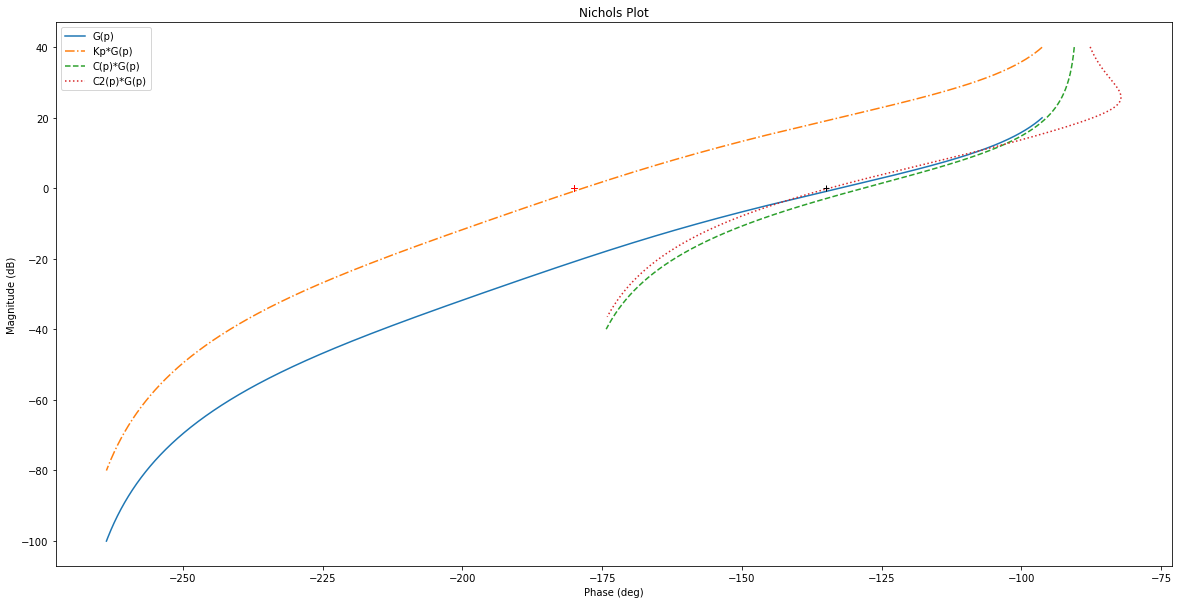

In [6]:
tD = 15/w # tD trouvé par essais-erreurs
print(f"tau_D = {tD:.2f}s")
Corr2 = Kp*ml.tf([tD, 1],1)

fig = plt.figure("Nichols",figsize=(20,10))
ax = fig.subplots()
rlf.nichols(G, grid = False, labels=['G(p)'], NameOfFigure = "Nichols")
rlf.nichols(Kp*G, grid = False, labels=['Kp*G(p)'], NameOfFigure = "Nichols", linestyle = '-.')
rlf.nichols(Corr*G, grid = False, labels=['C(p)*G(p)'], NameOfFigure = "Nichols", linestyle = '--')
rlf.nichols(Corr2*G, grid = False, labels=['C2(p)*G(p)'], NameOfFigure = "Nichols", linestyle = ':')

ax.plot(-180+MP, 0,'k+'); # Ajout du repère (+) par lequel on est censé passer

gm, pm, wg, wp = ml.margin(Corr2*G) # Extrait la marge de gain (Gm) et de phase (Pm)
print(f"Le système ainsi corrigé présente une marge de phase de {pm:.2f}° et une marge de gain de {gm:.2f} dB.")

Les performances du système ainsi corrigé sont :


Système non corrigé
-------------------
DCGain : 0.9990781353814483
Overshoot : 20.71177518799896
Peak : 1.2060049527341057
PeakTime : 3.636378059961076
RiseTime : 1.5608835065561826
SettlingTime : 5.383265559354142

Système corrigé
---------------
DCGain : 0.9999777307493183
Overshoot : 21.339622232526946
Peak : 1.2133692009006183
PeakTime : 0.2787350938997572
RiseTime : 0.12281431340410756
SettlingTime : 0.6364985285986793


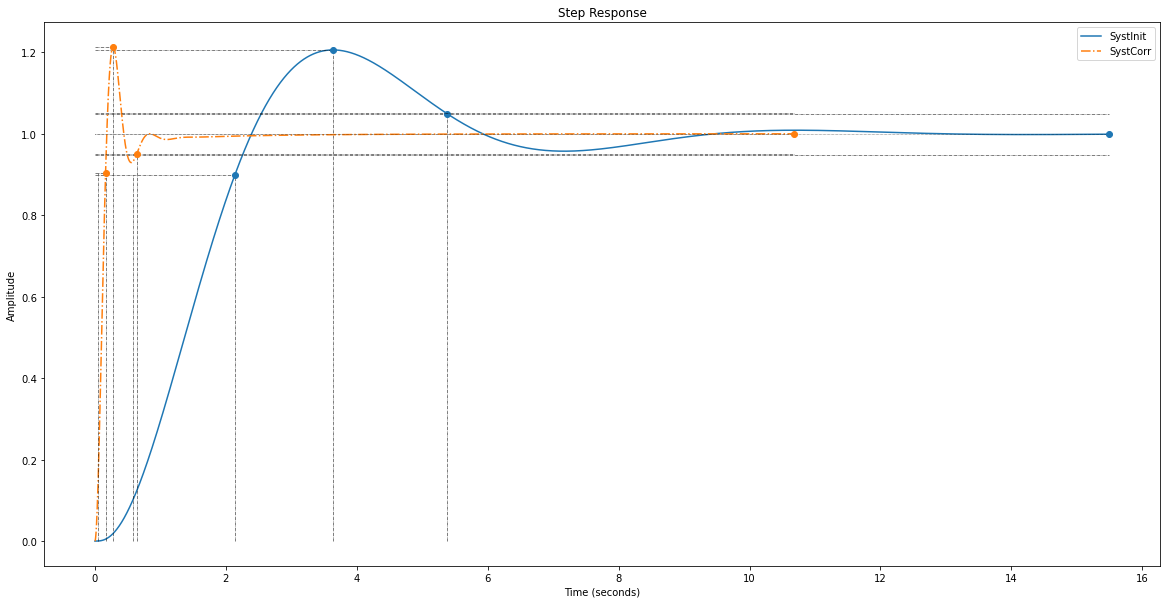

In [7]:
import warnings
warnings.filterwarnings("ignore", category=PendingDeprecationWarning) # Pour ignorer des message d'avertissement inutiles

# Système non corrigé
# -------------------

Gbf = ml.feedback(G,1)
fig = plt.figure("Step Response",figsize=(20,10))
info = rlf.stepWithInfo(Gbf, NameOfFigure="Step Response", sysName='SystInit') # Renvoie toutes les infos du step

ep = (1-info.DCGain)*100 # Erreur de position

gm, pm, wg, wp = ml.margin(G) # Extract the gain margin (Gm) and the phase margin (Pm)

print("\nSystème non corrigé")
print("-------------------")
rlf.printInfo(info)

# Système corrigé
# ---------------
Gbf_PD = ml.feedback(Corr2*G,1)
info_PD = rlf.stepWithInfo(Gbf_PD, NameOfFigure="Step Response", sysName='SystCorr', linestyle='-.') # Renvoie toutes les infos du step

ep_PD = (1-info_PD.DCGain)*100 # Erreur de position

gm, pm, wg, wp = ml.margin(Corr2*G) # Extract the gain margin (Gm) and the phase margin (Pm)

print("\nSystème corrigé")
print("---------------")
rlf.printInfo(info_PD)

L'erreur de vitesse du système original vaut 100.0% et celle du système corrigé vaut 10.0%.


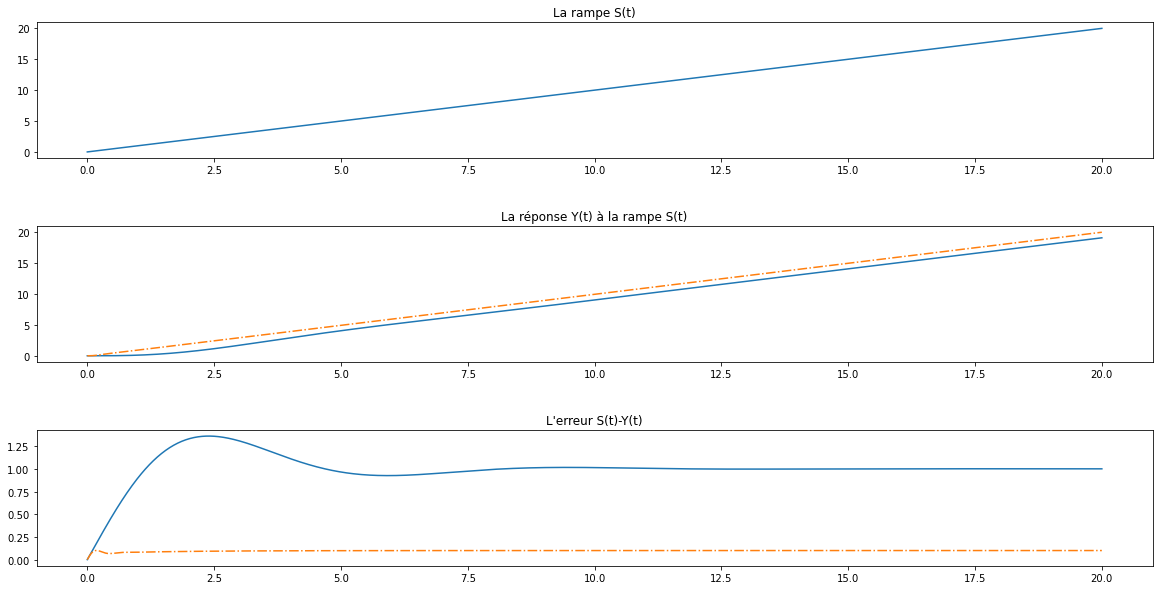

In [8]:
# Mesure de l'erreur de vitesse
t = np.linspace(0, 20, 1000)
s = t
warnings.filterwarnings('ignore') # Pour désactiver les warnings inutiles
[y, t, xout] = ml.lsim(Gbf,s,t) # Simuler la réponse à une rampe => erreur de vitesse
[y2, t, xout2] = ml.lsim(Gbf_PD,s,t) # Simuler la réponse à une rampe => erreur de vitesse
warnings.filterwarnings('default') # Pour réactiver les warnings

plt.figure("Erreur de vitesse",figsize=(20,10))
plt.subplot(3,1,1); plt.plot(t,s); plt.title("La rampe S(t)")
plt.subplot(3,1,2); plt.plot(t,y); plt.plot(t, y2, linestyle='-.'); plt.title("La réponse Y(t) à la rampe S(t)")
plt.subplot(3,1,3); plt.plot(t,(s-y)); plt.plot(t, (s-y2), linestyle='-.'); plt.title("L'erreur S(t)-Y(t)")
plt.subplots_adjust(hspace=0.5) # Pour laisser un peu d'espace pour les titres

ev = s[-1] - y[-1] # Erreur de vitesse système original
ev2 = s[-1] - y2[-1] # Erreur de vitesse du système corrigé

print(f"L'erreur de vitesse du système original vaut {ev*100:.1f}% et celle du système corrigé vaut {ev2*100:.1f}%.")

## Régulateur PID

Soit le système asservi à retour unitaire dont la fonction de boucle ouverte est :

$$
 H(p)=\frac{20}{(5+p)(2p+3)(4+3p)}
$$

On demande de déterminer le correcteur dont le but est de permettre une erreur statique nulle et une erreur de
vitesse minimale, tout en assurant une réponse indicielle dont le dépassement est limité à 5%.

:::{admonition} Stratégie de dimensionnement du correcteur adéquat
:class: dropdown
Puisqu'on cherche à avoir une erreur statique nulle, la théorie nous dit que le système doit être au moins de classe 1 (*cf. p. 6-3*). Or, il n'y a pas de pôle à l'origine ( = nous ne pouvons pas mettre de pôle en évidence) donc nous sommes avec un système de classe 0. Il faut dès lors augmenter la classe de notre système, ce qui peut se faire en intégrant ce dernier.

L'erreur de vitesse devant être minimale, il faudra fixer un K le plus grand possible vu qu'on obtient un système de classe 1 après l'avoir intégré et que l'erreur de vitesse est égale à $\frac{1}{K}$ dans ce cas.

Enfin, on doit limiter le dépassement à 5%, ce qui limitera notre K. Le problème est qu'on se retrouve avec un système d'ordre 3 à condition d'utiliser la technique de compensation du pôle dominant pour dimensionner $\tau_I$. Les pôles n'étant pas si différents, nous ne pouvons pas nous permettre de simplifier le système à un système du second ordre et nous devons donc ajouter un correcteur **D** par compensation du pôle dominant afin de réduire l'ordre de notre système et ainsi retrouver un système d'ordre 2 dont on connaît la forme canonique et pour lequel nous pouvons donc exploiter la technique de l'identifiaction pour fixer K.
:::

:::{admonition} Dimensionnement du correcteur
:class: dropdown
- En mettant la fonction de transfert sous forme canonique, on obtient:

$$
 H(p)=\frac{\frac{1}{3}}{(\frac{1}{5}p+1)(\frac{2}{3}p+1)(\frac{3}{4}p+1)}
$$

- Le pôle dominant étant celui lié à la constante de temps $\tau$ la plus grande, nous dimensionnons $\tau_I=\frac{3}{4}$

- Le second pôle dominant nous donne $\tau_D=\frac{2}{3}$

- Nous obtenons donc le correcteur PID suivant:

    $$
     C(p)=K_P*\frac{(\frac{2}{3}p+1)*(\frac{3}{4}p+1)}{\frac{3}{4}p}
    $$

    Ce qui nous donne comme fonction de transfert pour la boucle ouverte:

    $$
     G_{BO}(p) = \frac{K_P*\frac{1}{3}}{\frac{3}{4}p*(\frac{1}{5}p+1)} = \frac{\frac{4}{9}K_P}{\frac{1}{5}p^2+p}
    $$

- La boucle fermée étant à retour unitaire, on obtient:

$$
 G_{BF}(p) = \frac{\frac{4}{9}K_P}{\frac{1}{5}p^2+p+\frac{4}{9}K_P} = \frac{1}{\frac{9}{20K_P}*p^2+\frac{9}{4K_P}*p+1}
$$

- Par identification, on trouve:
  
    $$
    \begin{alignat*}{2}
        \left\{ \begin{aligned}
            \begin{array}{ll}
                \frac{2\zeta}{\omega_n} = \frac{9}{4K_P} \\
                \frac{1}{\omega_n^2} = \frac{9}{20K_P}
            \end{array}
        \end{aligned}\right.
    \end{alignat*}\
    $$
    
    Or,
    
    $$
    D_p=100*e^{-\frac{k\pi\zeta}{\sqrt{1-\zeta^2}}} \Rightarrow 5 = 100*e^{-\frac{\pi\zeta}{\sqrt{1-\zeta^2}}} \Rightarrow \zeta=0.69
    $$
    
    Ce qui nous permet de trouver:
    
    $$
    \left\{ \begin{aligned}
        \begin{array}{ll}
            K_P = 5.906 \\
            \omega_n = 3.623 rad/s
        \end{array}
    \end{aligned}\right.
    $$

- Le correcteur PID qui permet d'assurer un erreur statique nulle, une erreur de vitesse minimum et un dépassement de 5% pour le système donné est donc:

    $$
     C(p)=5.906*\frac{(\frac{2}{3}p+1)*(\frac{3}{4}p+1)}{\frac{3}{4}p}
    $$
:::


L'erreur de position du système original vaut 75.0% et celle du système corrigé vaut 0.0%.

Le dépassement du système original vaut 0.9% et celui du système corrigé vaut 5.0%.

L'erreur de vitesse du système original vaut 1530.3% et celle du système corrigé vaut 38.1%.


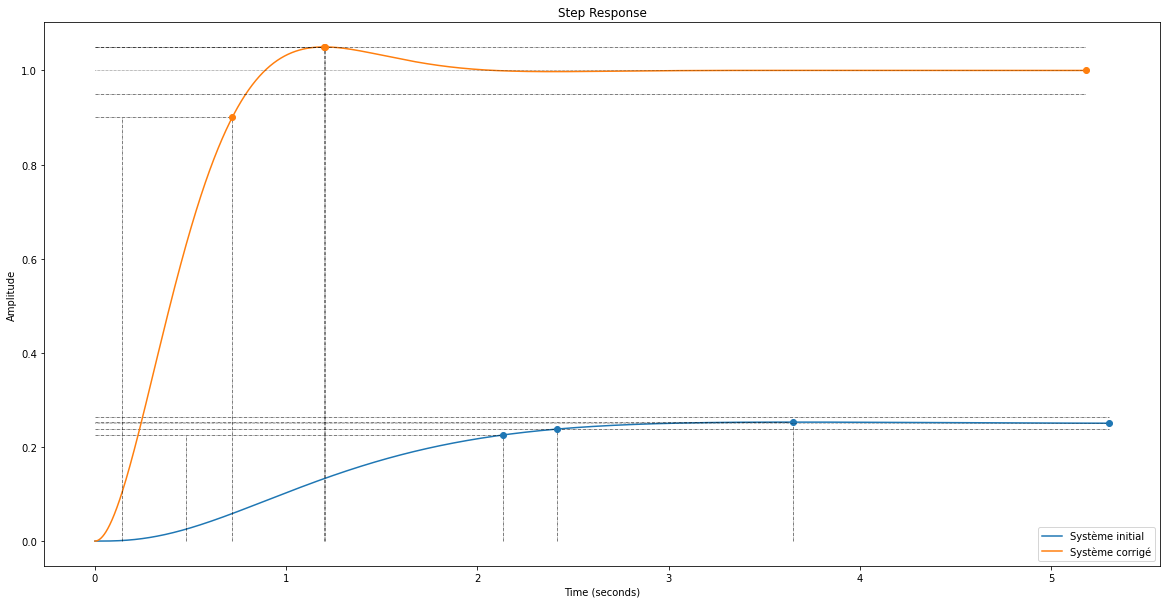

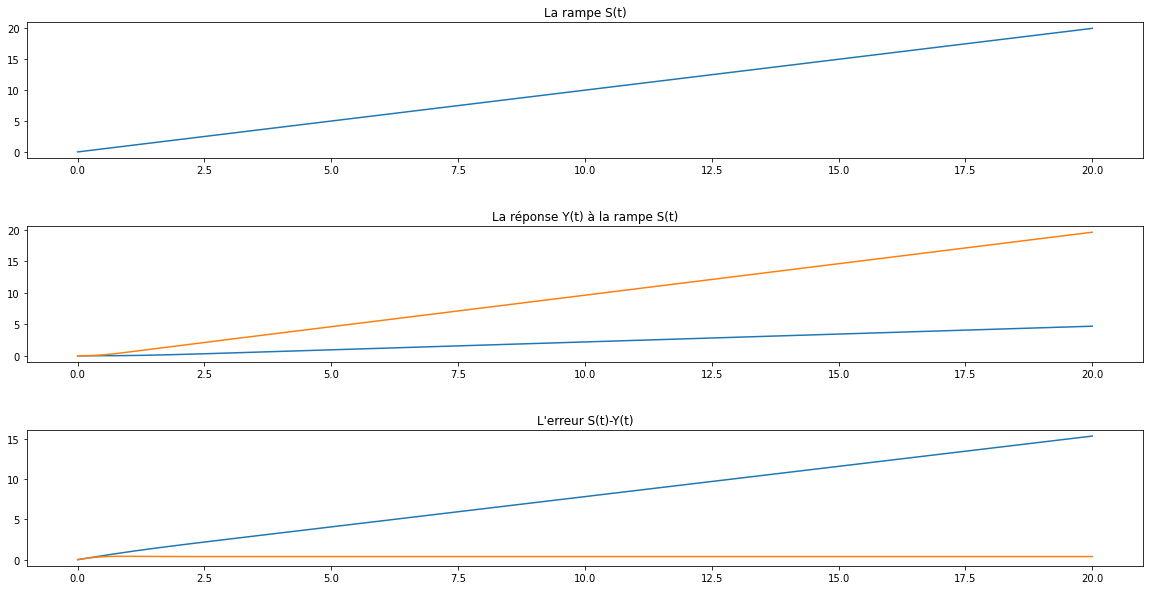

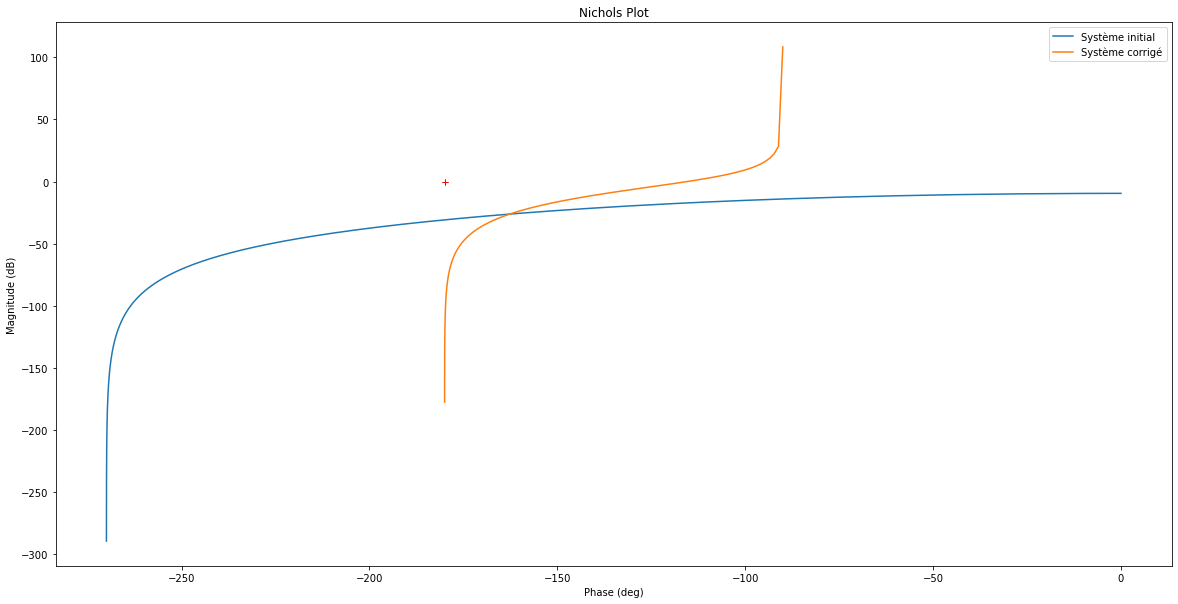

In [9]:
import warnings
warnings.filterwarnings("ignore", category=PendingDeprecationWarning) # Pour ignorer des message d'avertissement inutiles

# ------------------------
# Configuration du système
# ------------------------

# Système initial
num = 20
H1 = ml.tf(1, [1, 5])
H2 = ml.tf(1, [2, 3])
H3 = ml.tf(1, [3, 4])
H = num*H1*H2*H3  # H de l'énoncé
G_BF_init = ml.feedback(H, 1)

# Correcteur
Kp = 5.906
tI = 3/4
tD = 2/3
C = Kp*ml.tf([tI, 1],[tI, 0])*ml.tf([tD, 1],[1])

# Système corrigé
G_BO = C*H
G_BF = ml.feedback(G_BO, 1)

# ------------------
# Analyse du système
# ------------------

# Step
fig = plt.figure("Step Response",figsize=(20,10))
info = rlf.stepWithInfo(G_BF_init, NameOfFigure="Step Response", sysName='Système initial')
info_PID = rlf.stepWithInfo(G_BF, NameOfFigure="Step Response", sysName='Système corrigé')

# Erreurs statiques
e0_init = 1-info.DCGain
e0 = 1-info_PID.DCGain
print(f"\nL'erreur de position du système original vaut {e0_init*100:.1f}% et celle du système corrigé vaut {e0*100:.1f}%.")

# Dépassements
print(f"\nLe dépassement du système original vaut {info.Overshoot:.1f}% et celui du système corrigé vaut {info_PID.Overshoot:.1f}%.")

# Erreurs de vitesse
t = np.linspace(0, 20, 1000)
s = t
warnings.filterwarnings('ignore') # Pour désactiver les warnings inutiles
[y, t, xout] = ml.lsim(G_BF_init,s,t) # Simuler la réponse à une rampe => erreur de vitesse
[y2, t, xout2] = ml.lsim(G_BF,s,t) # Simuler la réponse à une rampe => erreur de vitesse
warnings.filterwarnings('default') # Pour réactiver les warnings

plt.figure("Erreur de vitesse",figsize=(20,10))
plt.subplot(3,1,1); plt.plot(t,s); plt.title("La rampe S(t)")
plt.subplot(3,1,2); plt.plot(t,y); plt.plot(t, y2); plt.title("La réponse Y(t) à la rampe S(t)")
plt.subplot(3,1,3); plt.plot(t,(s-y)); plt.plot(t, (s-y2)); plt.title("L'erreur S(t)-Y(t)")
plt.subplots_adjust(hspace=0.5) # Pour laisser un peu d'espace pour les titres

ev = s[-1] - y[-1] # Erreur de vitesse système original
ev2 = s[-1] - y2[-1] # Erreur de vitesse du système corrigé

print(f"\nL'erreur de vitesse du système original vaut {ev*100:.1f}% et celle du système corrigé vaut {ev2*100:.1f}%.")

# Nichols (pas nécessaire ici mais toujours intéressant à observer)
fig = plt.figure("Nichols",figsize=(20,10))
frequencies = np.linspace(10**-5, 10**5, 10**6) # Pour bien voir vers où on converge dans les hautes fréquences (jusqu'à 10^5 rad/s ici)
rlf.nichols(H, grid = False, labels=['Système initial'], NameOfFigure = "Nichols", omega=frequencies)
rlf.nichols(G_BO, grid = False, labels=['Système corrigé'], NameOfFigure = "Nichols", omega=frequencies)

On voit donc bien que l'ajout de notre correcteur PID au système à retour unitaire initial nous permet d'avoir une erreur statique nulle, un dépassement de 5% et une erreur de vitesse limitée (38,1%) alors que ce dernier présentait une erreur statique de 75%, un dépassement de 0.9% et une erreur de vitesse infinie.

### [Facultatif] Exercice 7 page 7-18 (résolution dans les notes)